# Лабораторная работа №7 (Проведение исследований с моделями семантической сегментации)

## Выбор начальных условий

### Обоснование выбора набора данных
Использование изображений автомобилей для задач семантической сегментации имеет значительное практическое применение в области автомобильной промышленности, систем помощи водителю и компьютерного зрения. Этот набор данных позволяет моделям автоматизировать процесс точной идентификации различных частей автомобиля, таких как колеса, окна, корпус и фары. Это критически важно для таких областей, как автоматический контроль качества на производстве, создание систем помощи при парковке, диагностика повреждений автомобиля и разработка автономных транспортных средств. Семантическая сегментация не только классифицирует компоненты, но и определяет их точное расположение и форму на изображении, что способствует более детальному анализу конструкции автомобиля и повышает точность технических систем распознавания.

### Выбор метрики
Для оценки качества семантической сегментации частей автомобиля важно использовать метрику, которая отражает точность и полноту классификации. В данной работе выбрана метрика IoU (Intersection over Union). Эта метрика измеряет степень перекрытия между предсказанными и истинными областями на изображении для каждой части автомобиля. IoU является критически важным показателем качества, поскольку показывает, насколько точно модель находит и локализует различные компоненты, такие как колеса, окна, корпус и фары. Она обеспечивает всестороннюю оценку модели, особенно в контексте сложных форм и перекрывающихся элементов автомобиля, что имеет решающее значение для приложений, требующих высокой точности распознавания деталей транспортных средств.

## Подготовка данных

Импортируем основные библиотеки, которые будем использовать для обработки данных и создания модели.

In [6]:
import kagglehub
import os
import numpy as np
import random
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import shutil
import cv2

Загружаем датасет и устанавливаем значения констант

In [7]:
path = kagglehub.dataset_download("intelecai/car-segmentation")

100%|██████████| 442M/442M [00:37<00:00, 12.4MB/s] 

Extracting files...


преобразуем датасет в формат, где каждый класс обозначается отдельным цветом, чтобы  легче было визуализировать

In [ ]:
def convert_masks_to_color_representation(dataset_path, backup=True):
    """
    Преобразует все маски из индексного представления (где каждый пиксель имеет значение 0-4 во всех каналах)
    в цветовое представление в соответствии с VISUALIZATION_COLORS.

    Args:
        dataset_path: Путь к корневой директории датасета
        backup: Если True, создает резервную копию оригинальных масок
    """
    # Цветовая схема для классов
    VISUALIZATION_COLORS = {
        0: [0, 0, 0],        # Черный для фона
        1: [255, 0, 0],      # Красный для машины
        2: [255, 255, 0],    # Желтый для колес
        3: [0, 255, 0],      # Зеленый для фар
        4: [0, 0, 255]       # Синий для окон
    }

    # Найдем все подпапки с масками
    mask_dirs = []
    for root, dirs, files in os.walk(dataset_path):
        if os.path.basename(root) == 'masks':
            mask_dirs.append(root)

    if not mask_dirs:
        print(f"Не найдены папки с масками в {dataset_path}")
        return

    # Обрабатываем каждую директорию с масками
    for mask_dir in mask_dirs:
        print(f"Обработка масок в {mask_dir}")

        # Создаем резервную копию, если требуется
        if backup:
            backup_dir = os.path.join(os.path.dirname(mask_dir), 'masks_backup')
            if not os.path.exists(backup_dir):
                print(f"Создание резервной копии в {backup_dir}")
                shutil.copytree(mask_dir, backup_dir)

        # Получаем список всех файлов масок
        mask_files = [f for f in os.listdir(mask_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

        # Обрабатываем каждую маску
        for mask_file in tqdm(mask_files, desc="Преобразование масок"):
            mask_path = os.path.join(mask_dir, mask_file)

            try:
                # Загружаем маску как RGB
                mask_img = Image.open(mask_path).convert("RGB")
                mask_data = np.array(mask_img)

                # Создаем новую маску с цветовым представлением
                new_mask = np.zeros_like(mask_data)

                # Преобразуем индексы в цвета
                # Предполагаем, что значения RGB одинаковы во всех каналах и представляют индекс класса
                for class_idx, color in VISUALIZATION_COLORS.items():
                    # Находим все пиксели с данным индексом класса
                    mask_indices = (mask_data[:,:,0] == class_idx) & (mask_data[:,:,1] == class_idx) & (mask_data[:,:,2] == class_idx)

                    # Устанавливаем соответствующий цвет
                    new_mask[mask_indices] = color

                # Сохраняем новую маску, перезаписывая старую
                new_mask_img = Image.fromarray(new_mask.astype(np.uint8))
                new_mask_img.save(mask_path)

            except Exception as e:
                print(f"Ошибка при обработке {mask_path}: {e}")

        print(f"Преобразование завершено для {mask_dir}")

In [9]:
convert_masks_to_color_representation(path)

Обработка масок в /home/jupyter/.cache/kagglehub/datasets/intelecai/car-segmentation/versions/2/car-segmentation/masks
Создание резервной копии в /home/jupyter/.cache/kagglehub/datasets/intelecai/car-segmentation/versions/2/car-segmentation/masks_backup


Преобразование масок:   0%|          | 0/211 [00:00<?, ?it/s]

Преобразование завершено для /home/jupyter/.cache/kagglehub/datasets/intelecai/car-segmentation/versions/2/car-segmentation/masks


Разобъем датасет на тренировочные и тестовые наборы

In [ ]:
def prepare_car_segmentation_dataset(source_path, destination_path, train_ratio=0.8, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    train_dir = os.path.join(destination_path, "train")
    test_dir = os.path.join(destination_path, "test")

    train_images_dir = os.path.join(train_dir, "images")
    train_masks_dir = os.path.join(train_dir, "masks")
    test_images_dir = os.path.join(test_dir, "images")
    test_masks_dir = os.path.join(test_dir, "masks")

    os.makedirs(train_images_dir, exist_ok=True)
    os.makedirs(train_masks_dir, exist_ok=True)
    os.makedirs(test_images_dir, exist_ok=True)
    os.makedirs(test_masks_dir, exist_ok=True)

    images_dir = os.path.join(source_path, "images")
    masks_dir = os.path.join(source_path, "masks")

    image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
    mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

    if len(image_files) != len(mask_files):
        print("Предупреждение: количество изображений и масок не совпадает!")

    paired_files = list(zip(image_files, mask_files))
    random.shuffle(paired_files)

    # Разделяем на обучающую и тестовую выборки
    split_idx = int(len(paired_files) * train_ratio)
    train_pairs = paired_files[:split_idx]
    test_pairs = paired_files[split_idx:]

    print(f"Копирование файлов: {len(train_pairs)} в train, {len(test_pairs)} в test")

    for img_file, mask_file in train_pairs:
        shutil.copy2(os.path.join(images_dir, img_file), os.path.join(train_images_dir, img_file))
        shutil.copy2(os.path.join(masks_dir, mask_file), os.path.join(train_masks_dir, mask_file))

    for img_file, mask_file in test_pairs:
        shutil.copy2(os.path.join(images_dir, img_file), os.path.join(test_images_dir, img_file))
        shutil.copy2(os.path.join(masks_dir, mask_file), os.path.join(test_masks_dir, mask_file))

    print(f"Датасет успешно разделен и сохранен в {destination_path}")
    print(f"Обучающая выборка: {len(train_pairs)} изображений")
    print(f"Тестовая выборка: {len(test_pairs)} изображений")

In [11]:
prepare_car_segmentation_dataset(os.path.join(path, "car-segmentation"), os.path.join(path, '..', 'done'))

Копирование файлов: 168 в train, 43 в test
Датасет успешно разделен и сохранен в /home/jupyter/.cache/kagglehub/datasets/intelecai/car-segmentation/versions/2/../done
Обучающая выборка: 168 изображений
Тестовая выборка: 43 изображений


In [12]:
path = os.path.join(path, '..', 'done')
path

'/home/jupyter/.cache/kagglehub/datasets/intelecai/car-segmentation/versions/2/../done'

Определим глобальные константы для работы

In [13]:
TRAIN_DIR = os.path.join(path, 'train')
TEST_DIR = os.path.join(path, 'test')


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 256
NUM_CLASSES = 5
ENCODER = "resnet34"

In [29]:
COLOR_TO_LABEL = {
    (0/255, 0/255, 0/255): 0,
    (255/255, 0/255, 0/255): 1,
    (255/255, 255/255, 0/255): 2,
    (0/255, 255/255, 0/255): 3,
    (0/255, 0/255, 255/255): 4,
}
CLASS_NAMES = {
    0: "Background",
    1: "car",
    2: "wheel",
    3: "lights",
    4: "window"
}
VISUALIZATION_COLORS = {
    0: [0, 0, 0],        # Черный для фона
    1: [255, 0, 0],      # Красный для машины
    2: [255, 255, 0],    # Желтый для колес
    3: [0, 255, 0],      # Зеленый для фар
    4: [0, 0, 255]       # Синий для окон
}

def rgb_to_id_mask_nearest(rgb_mask, color_map=COLOR_TO_LABEL):
    h, w, c = rgb_mask.shape

    rgb_norm = rgb_mask.astype(np.float32) / 255.0

    colors = np.array(list(color_map.keys()))
    labels = np.array(list(color_map.values()))

    pixels = rgb_norm.reshape(-1, c)

    distances = cdist(pixels, colors, 'euclidean')
    nearest_indices = np.argmin(distances, axis=1)

    pixel_labels = labels[nearest_indices]

    id_mask = pixel_labels.reshape(h, w).astype(np.uint8)

    return id_mask

Напишем класс для загрузки данных

In [30]:
class SUIMDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.images_dir = os.path.join(root_dir, 'images')
        self.masks_dir = os.path.join(root_dir, 'masks')
        self.transform = transform
        self.image_filenames = sorted(os.listdir(self.images_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.image_filenames[idx].replace('.jpg', '.bmp'))

        image = np.array(Image.open(image_path).convert("RGB"))
        rgb_mask = np.array(Image.open(mask_path).convert("RGB"))
        mask = rgb_to_id_mask_nearest(rgb_mask)

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image = transformed['image']
            mask = transformed['mask']

        return image, mask

Зададим стандартное преобразование изображений для обучения

In [31]:
base_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])


Разобъём выборку на обучающую и валидационную

In [32]:
all_images = sorted(os.listdir(os.path.join(TRAIN_DIR, 'images')))
train_images, val_images = train_test_split(all_images, test_size=0.1, random_state=42)

class SUIMSubset(Dataset):
    def __init__(self, dataset, indices):
        self.dataset = dataset
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return self.dataset[self.indices[idx]]

full_dataset = SUIMDataset(TRAIN_DIR, transform=None)
train_indices = [i for i, img_name in enumerate(full_dataset.image_filenames) if img_name in train_images]
val_indices = [i for i, img_name in enumerate(full_dataset.image_filenames) if img_name in val_images]

train_dataset = SUIMSubset(SUIMDataset(TRAIN_DIR, transform=base_transform), train_indices)
val_dataset = SUIMSubset(SUIMDataset(TRAIN_DIR, transform=base_transform), val_indices)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print(f"Количество тренировочных изображений: {len(train_dataset)}")
print(f"Количество валидационных изображений: {len(val_dataset)}")


Количество тренировочных изображений: 151
Количество валидационных изображений: 17


Основные методы отображения картинок

In [33]:
def visualize_sample(dataset, idx=0):
    img, mask = dataset[idx]

    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).cpu().numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()


    colors = []
    for label in range(NUM_CLASSES):
        for color, lbl in COLOR_TO_LABEL.items():
            if lbl == label:
                rgb_color = [int(c*255) for c in color]
                colors.append(rgb_color)
                break

    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    for i, color in enumerate(colors):
        colored_mask[mask == i] = color

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Изображение")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(colored_mask)
    plt.title("Маска сегментации")
    plt.axis('off')

    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=np.array(color)/255,
                            label=f'{CLASS_NAMES[i]}')
                      for i, color in enumerate(colors)]
    plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def visualize_predictions(model, dataset, device, num_samples=3):
    np.random.seed(69+1)
    indices = np.random.choice(len(dataset), num_samples, replace=False)

    colors = []
    for label in range(NUM_CLASSES):
        for color, lbl in COLOR_TO_LABEL.items():
            if lbl == label:
                rgb_color = [int(c*255) for c in color]
                colors.append(rgb_color)
                break

    for idx in indices:
        image, mask = dataset[idx]
        image_tensor = image.unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(image_tensor)
            prediction = torch.argmax(output, dim=1).squeeze().cpu().numpy()

        if isinstance(image, torch.Tensor):
            image = image.permute(1, 2, 0).cpu().numpy()
            image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image = np.clip(image, 0, 1)

        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().numpy()

        colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
        for i, color in enumerate(colors):
            colored_mask[mask == i] = color

        colored_pred = np.zeros((prediction.shape[0], prediction.shape[1], 3), dtype=np.uint8)
        for i, color in enumerate(colors):
            colored_pred[prediction == i] = color

        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Изображение")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(colored_mask)
        plt.title("Истинная маска")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(colored_pred)
        plt.title("Предсказание модели")
        plt.axis('off')

        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=np.array(color)/255,
                                label=f'{CLASS_NAMES[i]}')
                          for i, color in enumerate(colors)]
        plt.legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        plt.show()


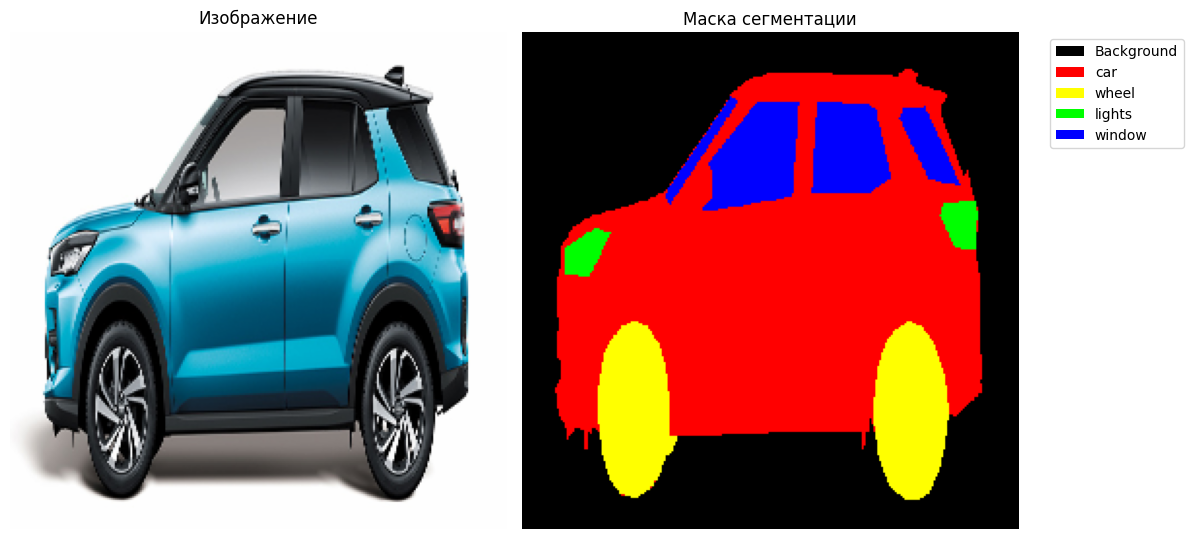

In [34]:
visualize_sample(train_dataset, idx=0)

метрика для обучения

In [35]:
def mean_iou(pred, target, num_classes=NUM_CLASSES):
    pred = torch.argmax(pred, dim=1)
    ious = []

    for cls in range(num_classes):
        pred_inds = pred == cls
        target_inds = target == cls

        if target_inds.long().sum().item() == 0 and pred_inds.long().sum().item() == 0:
            ious.append(torch.tensor(1.0, device=pred.device))
            continue

        intersection = (pred_inds & target_inds).float().sum()
        union = (pred_inds | target_inds).float().sum()

        iou = (intersection + 1e-8) / (union + 1e-8)
        ious.append(iou)

    return torch.stack(ious).mean()

## Обучение Unet

### Обычный бейзлайн

Определим две функции для обучения:

train_epoch —  обучает модель на одной эпохе данных, вычисляет градиенты и обновляет веса
validate_epoch — оценивает модель на валидационных данных без обновления весов

In [36]:
def train_epoch(model, loader, optimizer, criterion, device, metrics_fn=None):
    model.train()
    total_loss = 0
    total_metrics = 0

    with tqdm(loader, desc="Training", leave=False) as pbar:
        for images, masks in pbar:
            images = images.to(device)
            masks = masks.long().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            batch_loss = loss.item()
            total_loss += batch_loss

            if metrics_fn:
                metrics = metrics_fn(outputs, masks)
                total_metrics += metrics.item() if isinstance(metrics, torch.Tensor) else metrics
                pbar.set_postfix(loss=batch_loss, metrics=metrics.item() if isinstance(metrics, torch.Tensor) else metrics)
            else:
                pbar.set_postfix(loss=batch_loss)

    average_loss = total_loss / len(loader)
    average_metrics = total_metrics / len(loader) if metrics_fn else None

    return average_loss, average_metrics

def validate_epoch(model, loader, criterion, device, metrics_fn=None):
    model.eval()
    total_loss = 0
    total_metrics = 0

    with torch.no_grad():
        with tqdm(loader, desc="Validation", leave=False) as pbar:
            for images, masks in pbar:
                images = images.to(device)
                masks = masks.long().to(device)

                outputs = model(images)
                loss = criterion(outputs, masks)

                batch_loss = loss.item()
                total_loss += batch_loss

                if metrics_fn:
                    metrics = metrics_fn(outputs, masks)
                    total_metrics += metrics.item() if isinstance(metrics, torch.Tensor) else metrics
                    pbar.set_postfix(loss=batch_loss, metrics=metrics.item() if isinstance(metrics, torch.Tensor) else metrics)
                else:
                    pbar.set_postfix(loss=batch_loss)

    average_loss = total_loss / len(loader)
    average_metrics = total_metrics / len(loader) if metrics_fn else None

    return average_loss, average_metrics

и затем основная функция обучения и для отрисовки метрик при обучении

In [37]:
def train_model(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    device,
    epochs=10,
    scheduler=None,
    metrics_fn=None,
):
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_metrics': [],
        'val_metrics': []
    }

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        train_loss, train_metrics = train_epoch(
            model, train_loader, optimizer, criterion, device, metrics_fn
        )

        val_loss, val_metrics = validate_epoch(
            model, val_loader, criterion, device, metrics_fn
        )

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        if metrics_fn:
            history['train_metrics'].append(train_metrics)
            history['val_metrics'].append(val_metrics)

        if scheduler:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        print(f"Train Loss: {train_loss:.4f}")
        print(f"Val Loss: {val_loss:.4f}")
        if metrics_fn:
            print(f"Train Metrics: {train_metrics:.4f}")
            print(f"Val Metrics: {val_metrics:.4f}")
        print("-" * 30)

    return model, history

def plot_training_history(history, metrics_name="IoU"):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    if 'train_metrics' in history and len(history['train_metrics']) > 0:
        plt.subplot(1, 2, 2)
        plt.plot(history['train_metrics'], label='Train')
        plt.plot(history['val_metrics'], label='Validation')
        plt.title(metrics_name)
        plt.xlabel('Epoch')
        plt.legend()

    plt.tight_layout()
    plt.show()

Создаём модель

In [38]:
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

In [42]:
trained_model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    epochs=4,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)

Epoch 1/4


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.8994
Val Loss: 0.8093
Train Metrics: 0.3917
Val Metrics: 0.4136
------------------------------
Epoch 2/4


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.7192
Val Loss: 0.6686
Train Metrics: 0.4977
Val Metrics: 0.5322
------------------------------
Epoch 3/4


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.6127
Val Loss: 0.5788
Train Metrics: 0.5938
Val Metrics: 0.5688
------------------------------
Epoch 4/4


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.5313
Val Loss: 0.4974
Train Metrics: 0.6428
Val Metrics: 0.6160
------------------------------


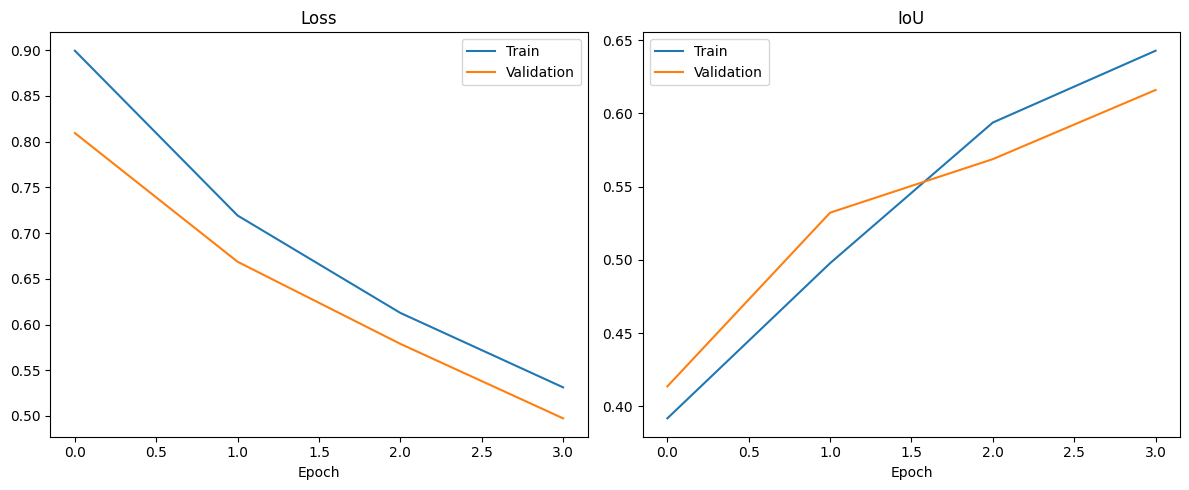

In [43]:
plot_training_history(history)

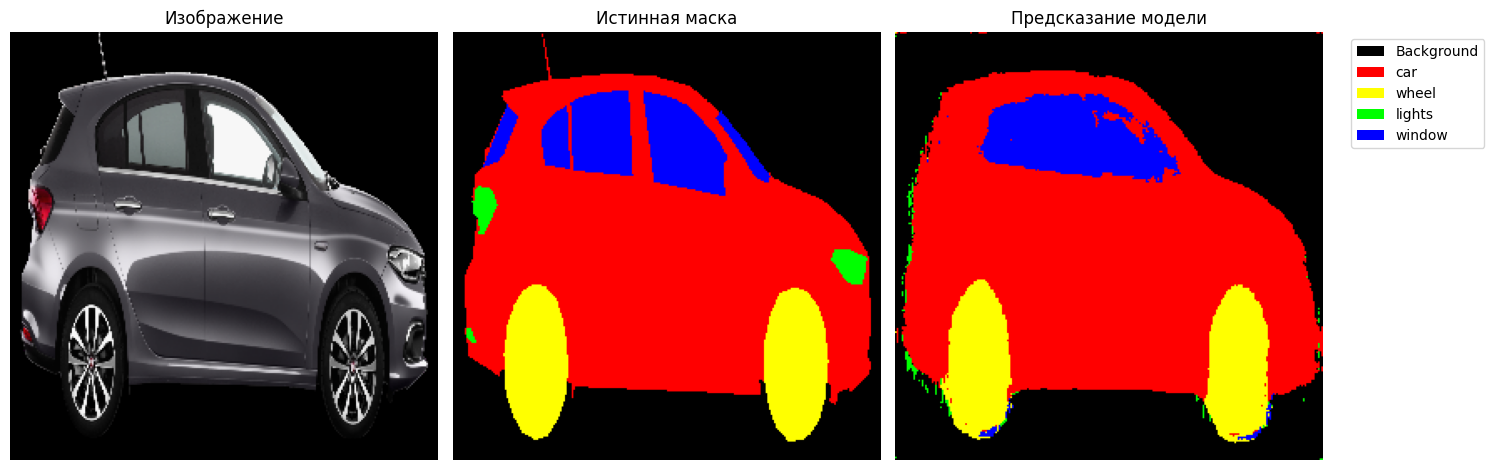

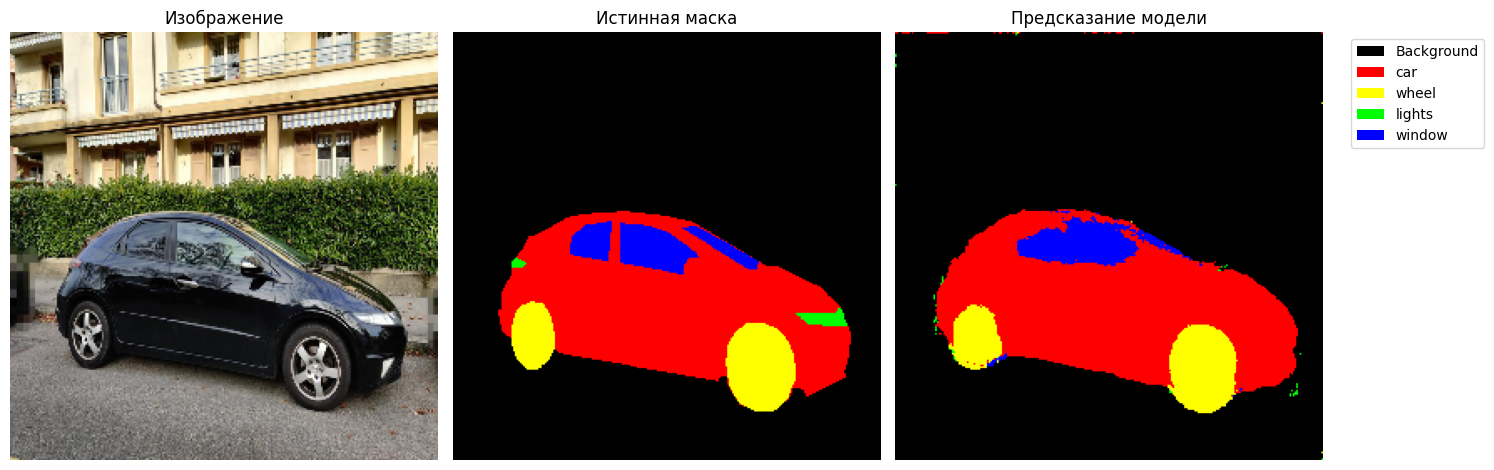

In [44]:
visualize_predictions(trained_model, train_dataset, DEVICE, num_samples=2)

Видно, что модель справилась с семантической сегментацией изображения. Видны основные объекты, и их классы соотвествуют разметке. Попробуем улучшить точность модели

### Улучшенный бейзлайн

Для улучшения точности модели попробуем применить следующие методы:
- разнообразить данные
- использовать более сложный энкодер

In [45]:
unet_improved = smp.Unet(
    encoder_name="efficientnet-b3",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
    activation=None
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet_improved.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/home/jupyter/.local/lib/python3.10/site-packages/segmentation_models_pytorch/encoders/__init__.py:136: UserWarning: Error loading efficientnet-b3 `imagenet` weights from Hugging Face Hub, trying loading from original url...
  warnings.warn(message, UserWarning)
Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b3-5fb5a3c3.pth" to /tmp/xdg_cache/torch/hub/checkpoints/efficientnet-b3-5fb5a3c3.pth
100%|██████████| 47.1M/47.1M [00:00<00:00, 97.6MB/s]


Определим аугментации для увеличения вариативности тренировочных изображений. Включим преобразования:

отражения, повороты, цветовые, деформации, шумы и фильтры, улучшение деталей
Эти преобразования помогают модели лучше обобщать и справляться с вариативностью в реальных данных.

In [70]:
improved_transform = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.OneOf([
        A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
        A.GridDistortion(p=0.5),
        A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5),
    ], p=0.3),
    A.OneOf([
        A.GaussNoise(p=0.3),
        A.Blur(blur_limit=(3, 7), p=0.3),
        A.GaussianBlur(blur_limit=(3, 7), sigma_limit=(0.1, 2.0), p=0.3),
    ], p=0.3),
    A.OneOf([
        A.CLAHE(clip_limit=2),
        A.Sharpen(),
        A.Emboss(),
    ], p=0.3),
    A.HueSaturationValue(p=0.3),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

In [71]:
improved_train_dataset = SUIMSubset(SUIMDataset(TRAIN_DIR, transform=improved_transform), train_indices)
improved_val_dataset = SUIMSubset(SUIMDataset(TRAIN_DIR, transform=base_transform), val_indices)

improved_train_loader = DataLoader(improved_train_dataset, batch_size=8, shuffle=True)
improved_val_loader = DataLoader(improved_val_dataset, batch_size=8, shuffle=False)

print(f"Количество тренировочных изображений: {len(improved_train_dataset)}")
print(f"Количество валидационных изображений: {len(improved_val_dataset)}")

Количество тренировочных изображений: 151
Количество валидационных изображений: 17


In [48]:
improved_trained_model, improved_history = train_model(
    model=unet_improved,
    train_loader=improved_train_loader,
    val_loader=improved_val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    epochs=5,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)

Epoch 1/5


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.5675
Val Loss: 1.4898
Train Metrics: 0.1307
Val Metrics: 0.1330
------------------------------
Epoch 2/5


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.2929
Val Loss: 1.1786
Train Metrics: 0.2139
Val Metrics: 0.2317
------------------------------
Epoch 3/5


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.0934
Val Loss: 0.9656
Train Metrics: 0.2754
Val Metrics: 0.3040
------------------------------
Epoch 4/5


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.9369
Val Loss: 0.7982
Train Metrics: 0.3175
Val Metrics: 0.3633
------------------------------
Epoch 5/5


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.7927
Val Loss: 0.6501
Train Metrics: 0.3680
Val Metrics: 0.4307
------------------------------


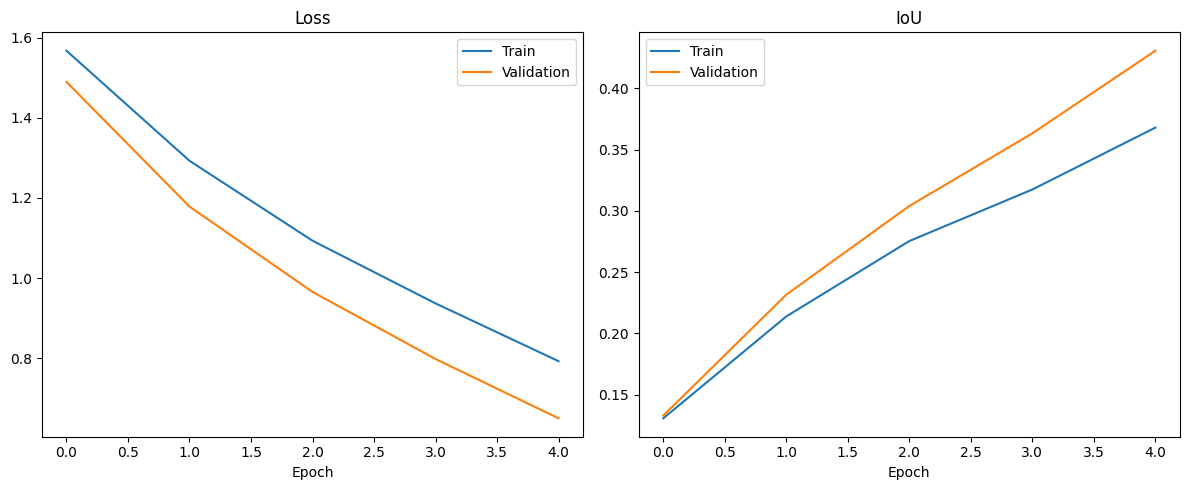

In [49]:
plot_training_history(improved_history)

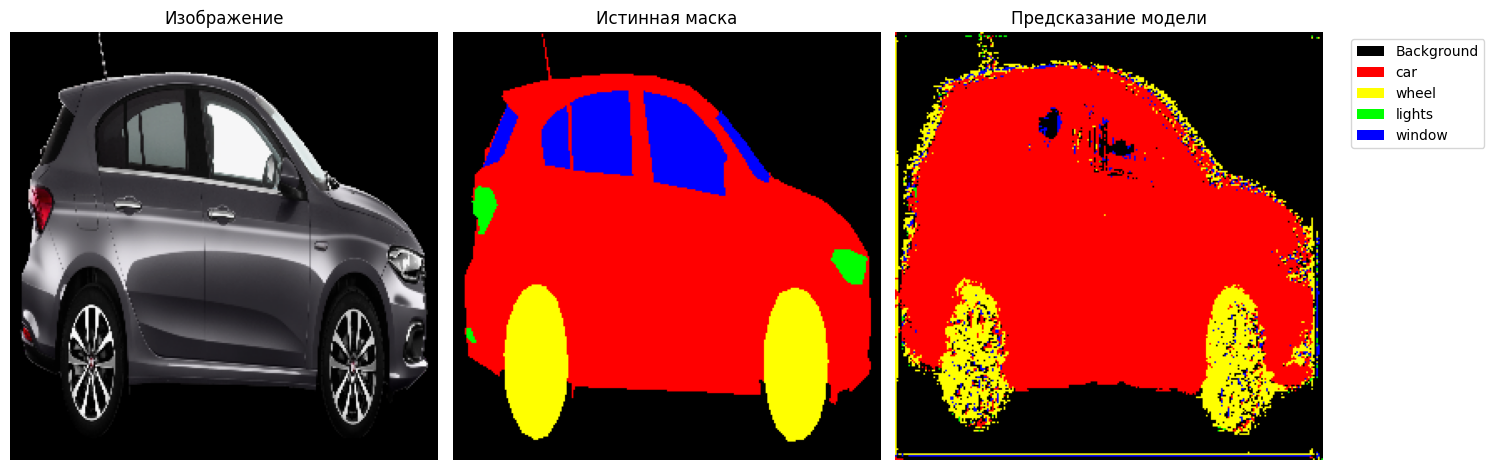

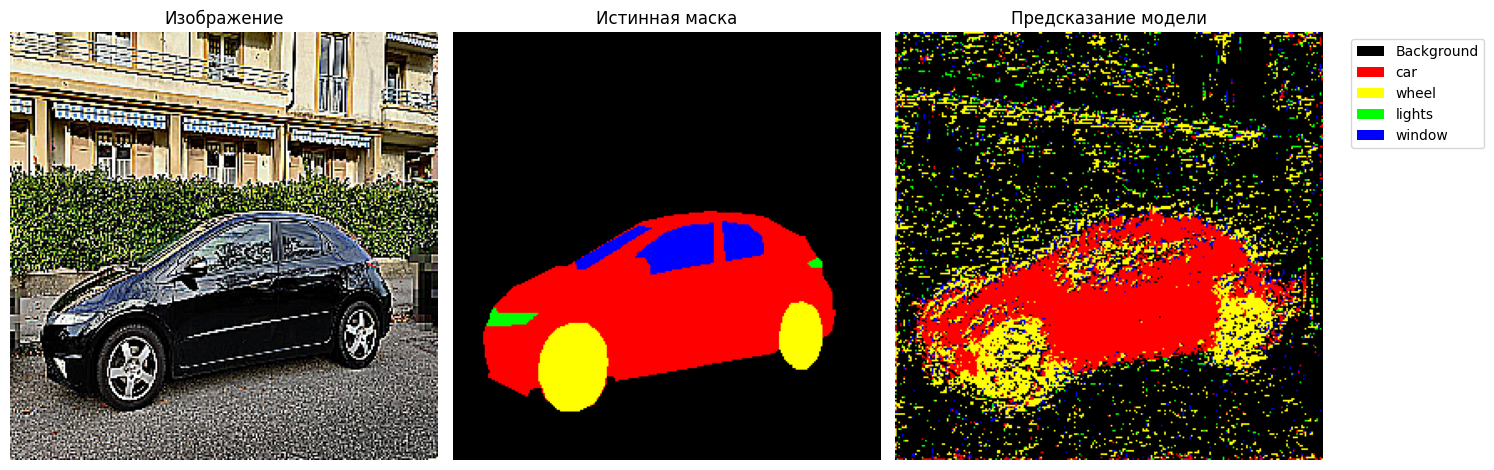

In [50]:
visualize_predictions(improved_trained_model, improved_train_dataset, DEVICE, num_samples=2)

По  результатам запусков, видно, что разнообразие данных негативно сказалось на работе модели. Вероятно это её запутало, и не дало до конца дообучиться. Либо сами преобразования ухудшили качество данных

### Собственная имплементация

Напишем свою простейшую реализацию UNet модели

In [51]:
class SimpleUNet(nn.Module):
    def __init__(self, num_classes=8):
        super().__init__()
        self.enc1 = self._conv_block(3, 32)
        self.enc2 = self._conv_block(32, 64)

        self.middle = self._conv_block(64, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self._conv_block(128, 64)  # 128 = 64 (от enc2) + 64 (от up1)

        self.up2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.dec2 = self._conv_block(64, 32)   # 64 = 32 (от enc1) + 32 (от up2)

        self.final = nn.Conv2d(32, num_classes, kernel_size=1)
        self.pool = nn.MaxPool2d(2)

    def _conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Энкодер
        e1 = self.enc1(x)
        p1 = self.pool(e1)
        e2 = self.enc2(p1)
        p2 = self.pool(e2)

        m = self.middle(p2)

        u1 = self.up1(m)
        u1 = torch.cat([u1, e2], dim=1)
        d1 = self.dec1(u1)

        u2 = self.up2(d1)
        u2 = torch.cat([u2, e1], dim=1)
        d2 = self.dec2(u2)

        return self.final(d2)

In [52]:
custom_unet = SimpleUNet().to(DEVICE)
custom_optimizer = torch.optim.Adam(custom_unet.parameters(), lr=1e-4)

In [53]:
trained_custom_unet, custom_history = train_model(
    model=custom_unet,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=custom_optimizer,
    device=DEVICE,
    epochs=3,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)

Epoch 1/3


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 2.0574
Val Loss: 2.0732
Train Metrics: 0.0654
Val Metrics: 0.0238
------------------------------
Epoch 2/3


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.8737
Val Loss: 1.6902
Train Metrics: 0.1458
Val Metrics: 0.2196
------------------------------
Epoch 3/3


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.7174
Val Loss: 1.5681
Train Metrics: 0.2222
Val Metrics: 0.2573
------------------------------


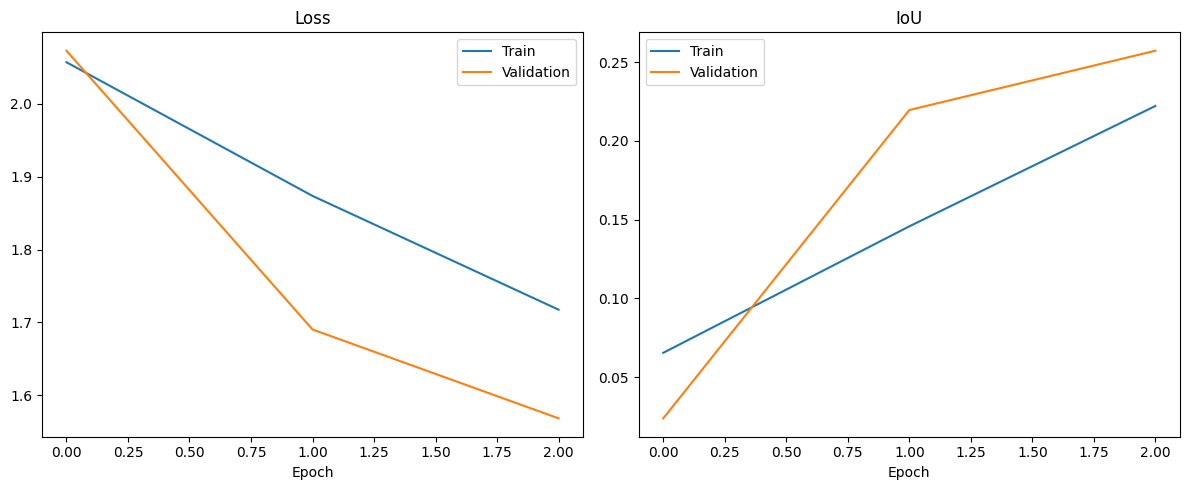

In [54]:
plot_training_history(custom_history)

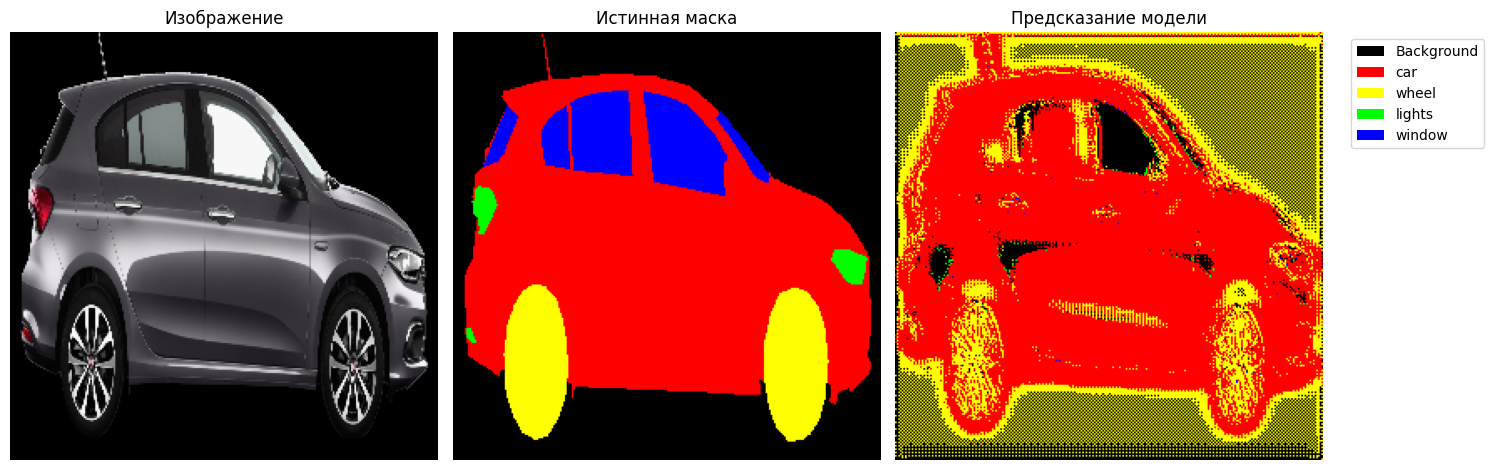

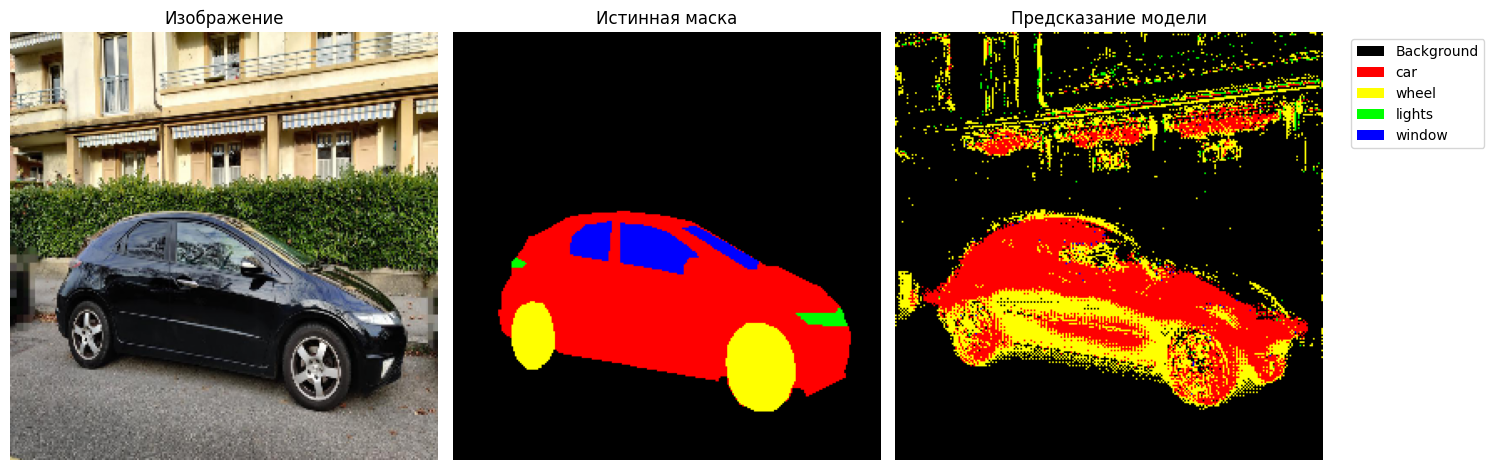

In [55]:
visualize_predictions(trained_custom_unet, train_dataset, DEVICE, num_samples=2)

Ожидаемо, модель не показала выдающихся результатов, попробуем улучшить её достижения

### Улучшенный бейзлайн собственной имплементаци

В этот раз, попробуем поменять архитектуру модели вместе с увеличением разнообразия данных

In [56]:
class ImprovedUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )

        self.final = nn.Conv2d(64, 8, kernel_size=1)

    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)

        u1 = self.up1(c3)
        d1 = self.dec1(torch.cat([u1, c2], dim=1))
        u2 = self.up2(d1)
        d2 = self.dec2(torch.cat([u2, c1], dim=1))
        return self.final(d2)

In [61]:
improved_custom_unet = SimpleUNet().to(DEVICE)
custom_optimizer = torch.optim.Adam(improved_custom_unet.parameters(), lr=1e-4)

In [62]:
trained_improved_custom_unet, custom_history = train_model(
    model=improved_custom_unet,
    train_loader=improved_train_loader,
    val_loader=improved_val_loader,
    criterion=criterion,
    optimizer=custom_optimizer,
    device=DEVICE,
    epochs=5,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)

Epoch 1/5


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.9994
Val Loss: 2.0121
Train Metrics: 0.0784
Val Metrics: 0.0345
------------------------------
Epoch 2/5


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.8363
Val Loss: 1.7477
Train Metrics: 0.1525
Val Metrics: 0.1900
------------------------------
Epoch 3/5


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.7144
Val Loss: 1.6008
Train Metrics: 0.2024
Val Metrics: 0.2235
------------------------------
Epoch 4/5


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 00017: reducing learning rate of group 0 to 1.2500e-05.
Train Loss: 1.6179
Val Loss: 1.6214
Train Metrics: 0.2458
Val Metrics: 0.2064
------------------------------
Epoch 5/5


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.5524
Val Loss: 1.5592
Train Metrics: 0.2568
Val Metrics: 0.2621
------------------------------


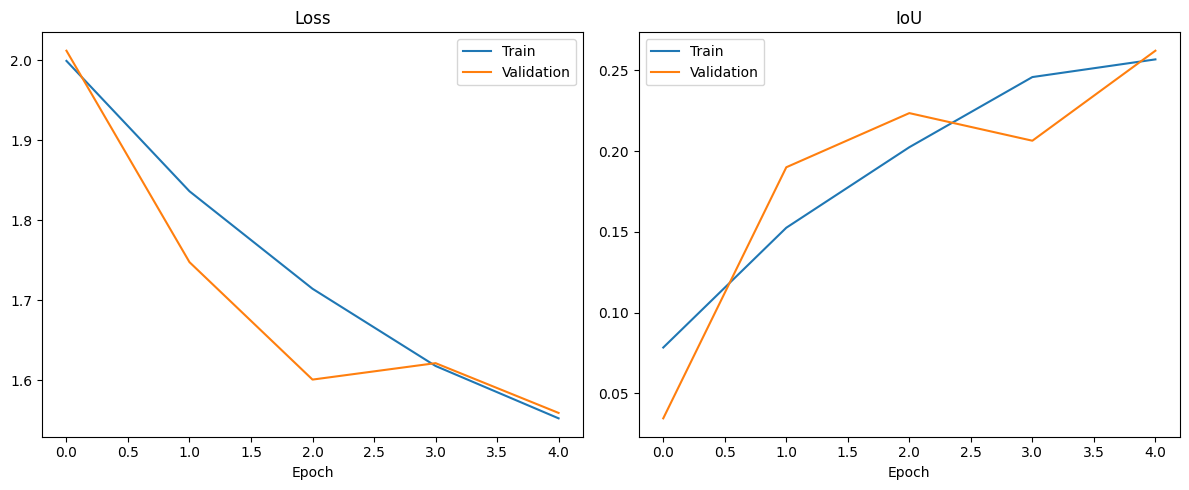

In [63]:
plot_training_history(custom_history)

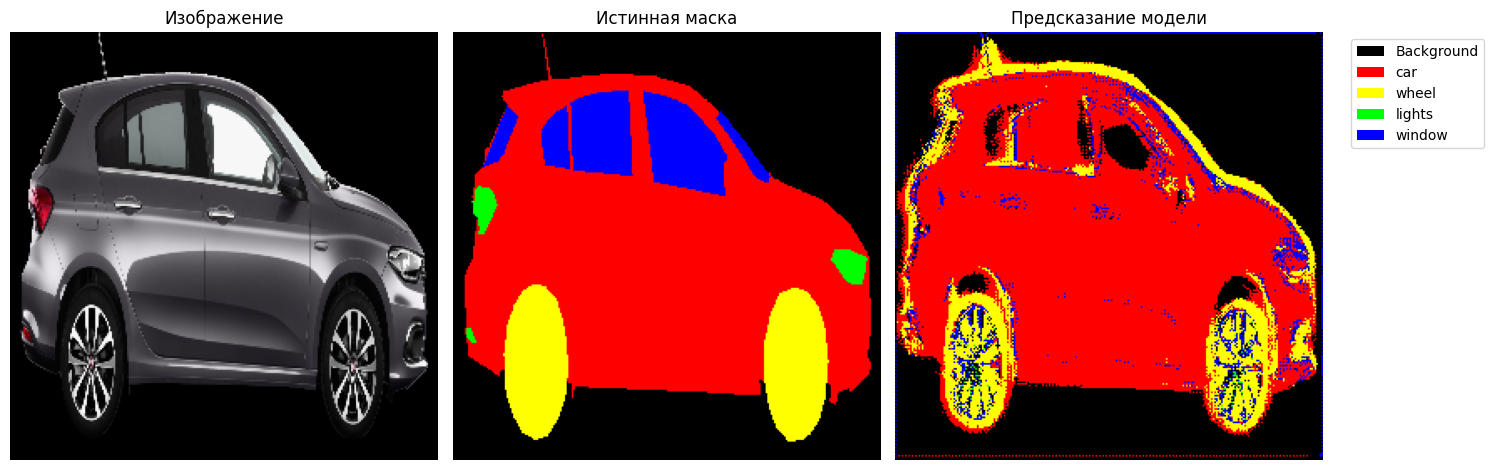

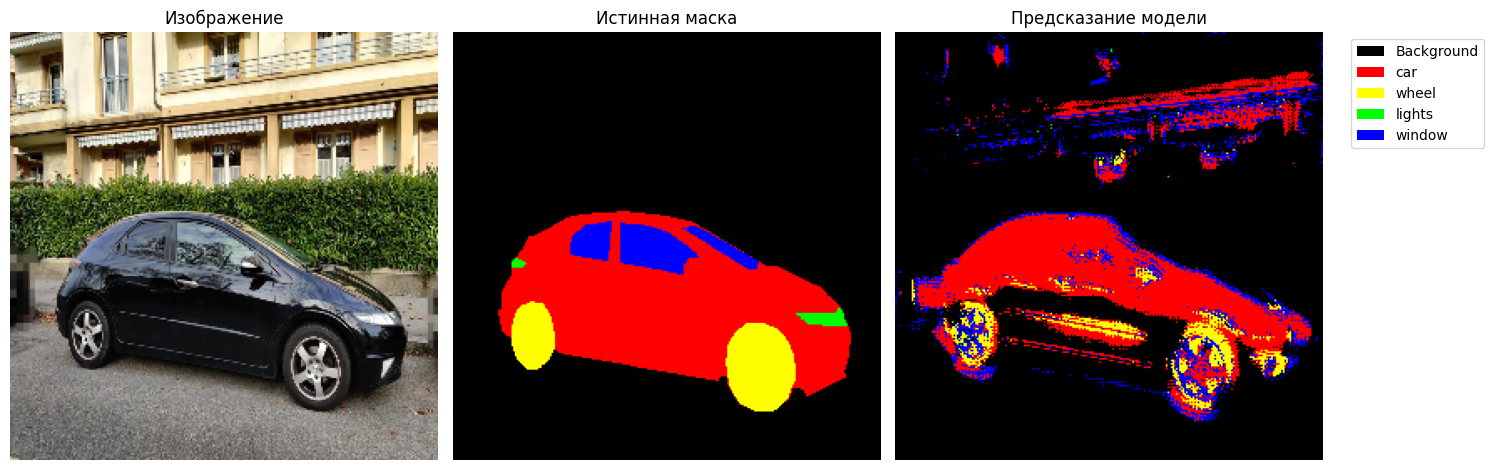

In [64]:
visualize_predictions(trained_improved_custom_unet, train_dataset, DEVICE, num_samples=2)

В целом видно присутсвие шума, ощутимых результатов добиться не получилось. Кажется модель недостаточно сильна для обощения данных на таком надобе, при таком количестве эпох. Посмотрим что получится у трансформерных моделей

## Обучение Segformer

### Обычный бейзлайн

In [65]:
segformer = smp.Segformer(
    encoder_name="mit_b0",
    encoder_weights="imagenet",
    in_channels=3,
    classes=NUM_CLASSES,
).to(DEVICE)

/home/jupyter/.local/lib/python3.10/site-packages/segmentation_models_pytorch/encoders/__init__.py:136: UserWarning: Error loading mit_b0 `imagenet` weights from Hugging Face Hub, trying loading from original url...
  warnings.warn(message, UserWarning)
Downloading: "https://github.com/qubvel/segmentation_models.pytorch/releases/download/v0.0.2/mit_b0.pth" to /tmp/xdg_cache/torch/hub/checkpoints/mit_b0.pth
100%|██████████| 13.7M/13.7M [00:00<00:00, 37.0MB/s]


In [66]:
optimizer = torch.optim.Adam(segformer.parameters(), lr=1e-4)

In [67]:
trained_segformer, history = train_model(
    model=segformer,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    epochs=3,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)

Epoch 1/3


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.9401
Val Loss: 0.5961
Train Metrics: 0.3664
Val Metrics: 0.4964
------------------------------
Epoch 2/3


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.3290
Val Loss: 0.3136
Train Metrics: 0.5646
Val Metrics: 0.5664
------------------------------
Epoch 3/3


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.2292
Val Loss: 0.2304
Train Metrics: 0.6194
Val Metrics: 0.5917
------------------------------


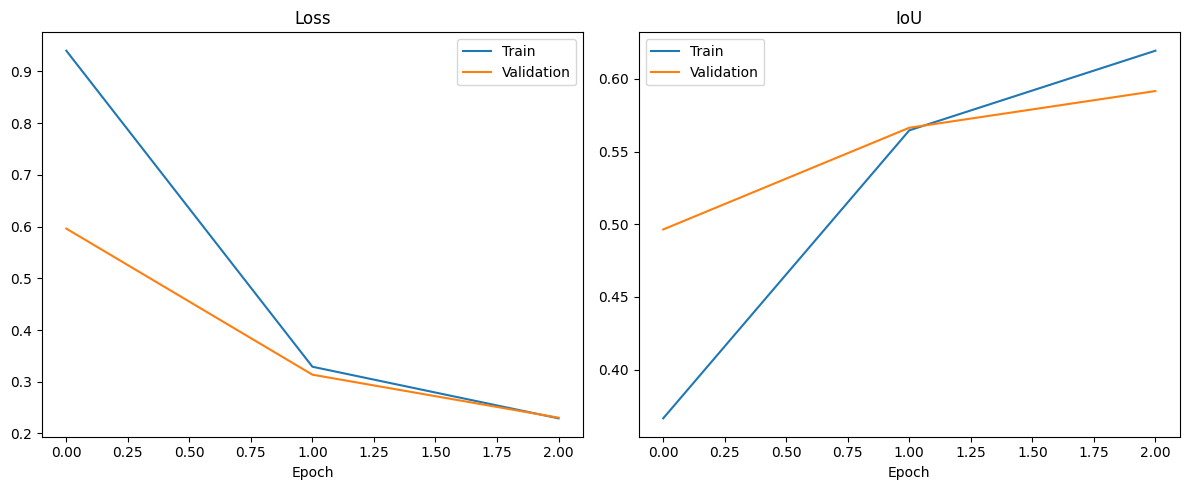

In [68]:
plot_training_history(history)

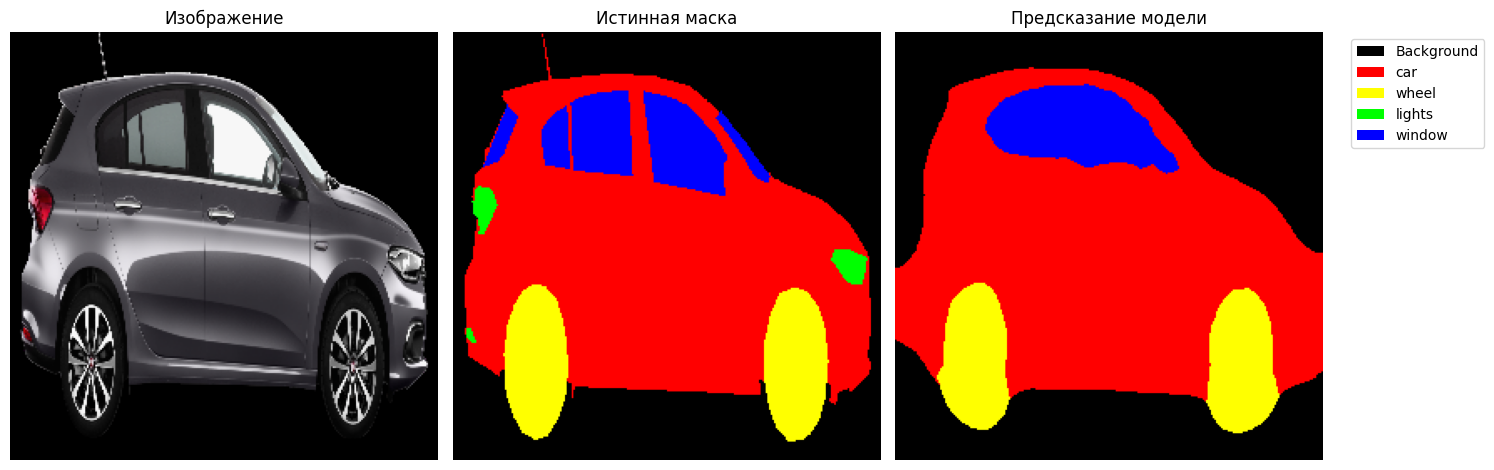

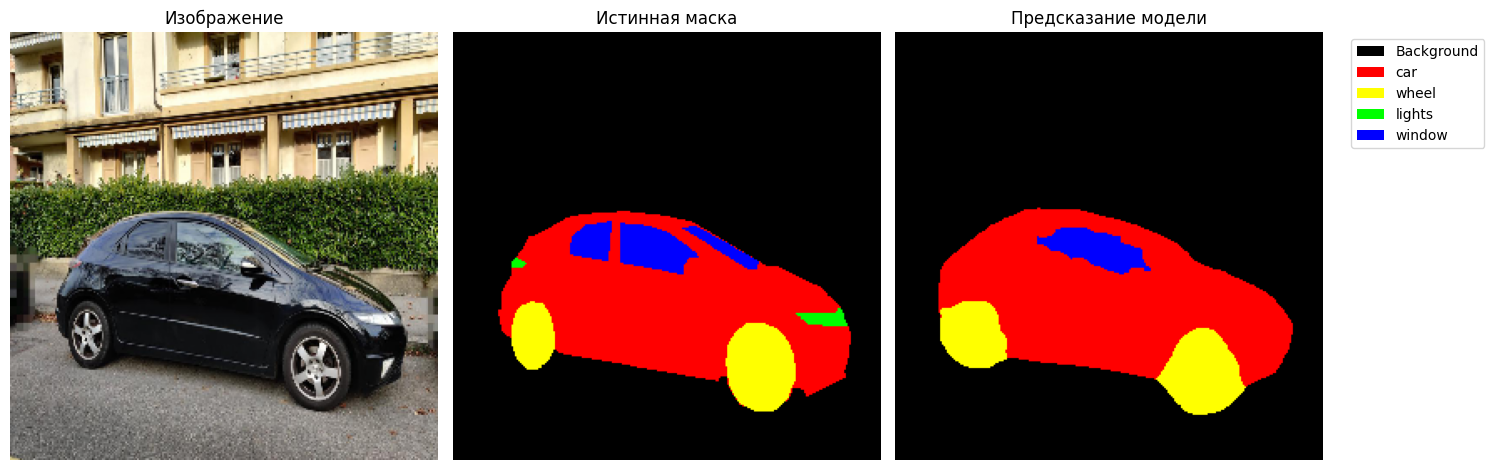

In [69]:
visualize_predictions(trained_segformer, train_dataset, DEVICE, num_samples=2)

Модель показала сопоставимый с UNet результат, попробуем добиться ещё более хорошего качества

### Улучшенный бейзлайн

In [72]:
improved_segformer, improved_history = train_model(
    model=segformer,
    train_loader=improved_train_loader,
    val_loader=improved_val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    epochs=4,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)

Epoch 1/4


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.2893
Val Loss: 0.2029
Train Metrics: 0.5822
Val Metrics: 0.6074
------------------------------
Epoch 2/4


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.2223
Val Loss: 0.2205
Train Metrics: 0.6117
Val Metrics: 0.6067
------------------------------
Epoch 3/4


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.1977
Val Loss: 0.1999
Train Metrics: 0.6427
Val Metrics: 0.6310
------------------------------
Epoch 4/4


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 0.1847
Val Loss: 0.1844
Train Metrics: 0.6524
Val Metrics: 0.6343
------------------------------


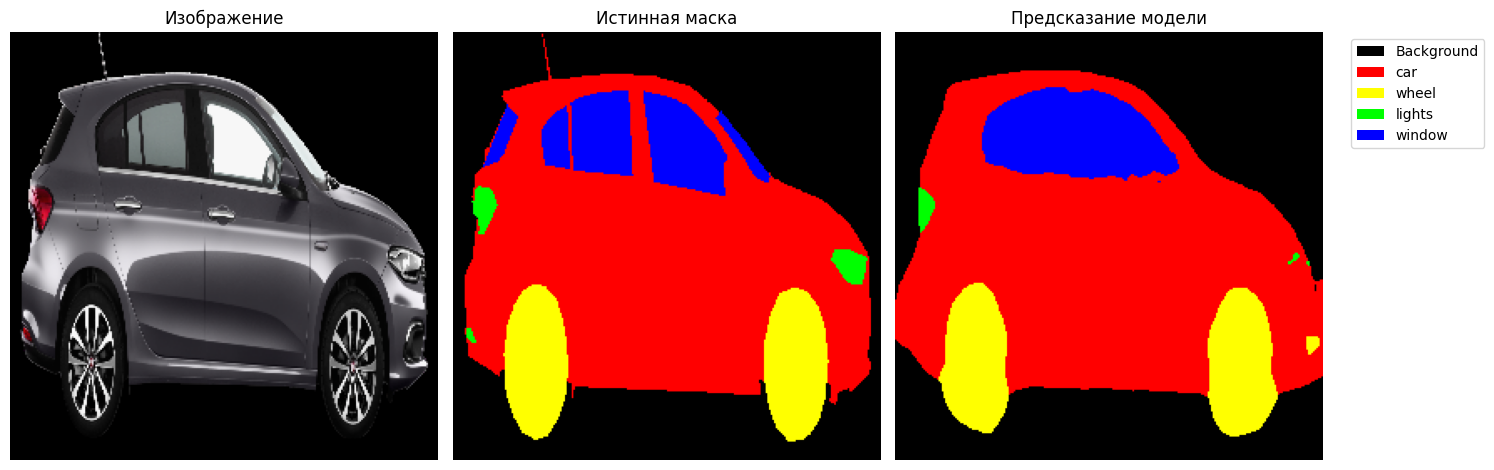

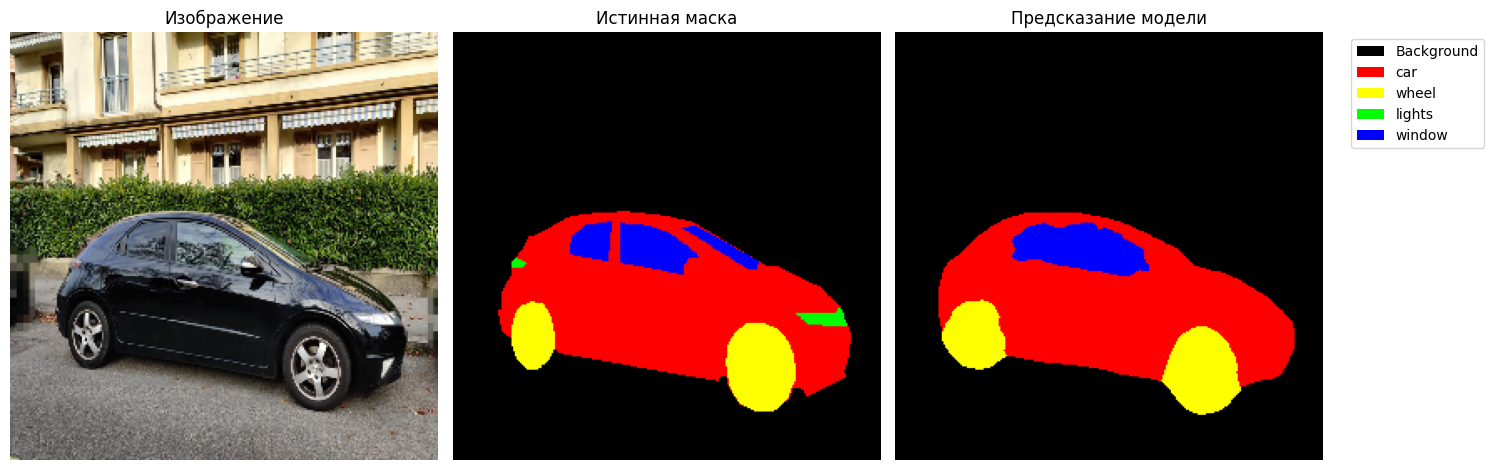

In [73]:
visualize_predictions(improved_segformer, train_dataset, DEVICE, num_samples=2)

Модель стала работать ощутимо лучше. Хорошо угадывает силует автомобиля и его отдельные детали. Хотя фары даются с трудом, что явно  из-за того, что площать фар значительно меньше, и моделе сложнее обучиться их находить

### Собственная имплементация

Попробуем написать собственную реализацию трансформенной модели с учетом размеров слоёв

In [74]:
class SimpleTransformerSegmentation(nn.Module):
    def __init__(self, img_size=256, patch_size=16, in_channels=3, num_classes=8,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=4, dropout=0.1):
        super().__init__()

        assert img_size % patch_size == 0, "Image size must be divisible by patch size"
        self.patch_size = patch_size
        self.img_size = img_size
        num_patches = (img_size // patch_size) ** 2

        self.patch_embed = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        self.dropout = nn.Dropout(dropout)

        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, num_heads, mlp_ratio, dropout)
            for _ in range(depth)
        ])

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(embed_dim, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, num_classes, kernel_size=2, stride=2)
        )


    def forward(self, x):
        input_size = x.shape[2:]

        x = self.patch_embed(x)

        B, C, H_embed, W_embed = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = x + self.pos_embed
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x)

        x = x.transpose(1, 2).reshape(B, C, H_embed, W_embed)

        x = self.decoder(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)

        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        x_norm = self.norm1(x)
        attn_output, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + attn_output

        x_norm = self.norm2(x)
        mlp_output = self.mlp(x_norm)
        x = x + mlp_output
        return x

In [75]:
custom_segformer = SimpleTransformerSegmentation(
    img_size=256,
    patch_size=16,
    in_channels=3,
    num_classes=NUM_CLASSES,
    embed_dim=256,
    depth=6,
    num_heads=8,
    dropout=0.1
).to(DEVICE)
optimizer = torch.optim.AdamW(custom_segformer.parameters(), lr=5e-5, weight_decay=1e-4)

Epoch 1/3


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.4546
Val Loss: 1.4480
Train Metrics: 0.1210
Val Metrics: 0.1447
------------------------------
Epoch 2/3


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.4030
Val Loss: 1.3558
Train Metrics: 0.1371
Val Metrics: 0.1481
------------------------------
Epoch 3/3


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.3617
Val Loss: 1.2955
Train Metrics: 0.1534
Val Metrics: 0.1679
------------------------------


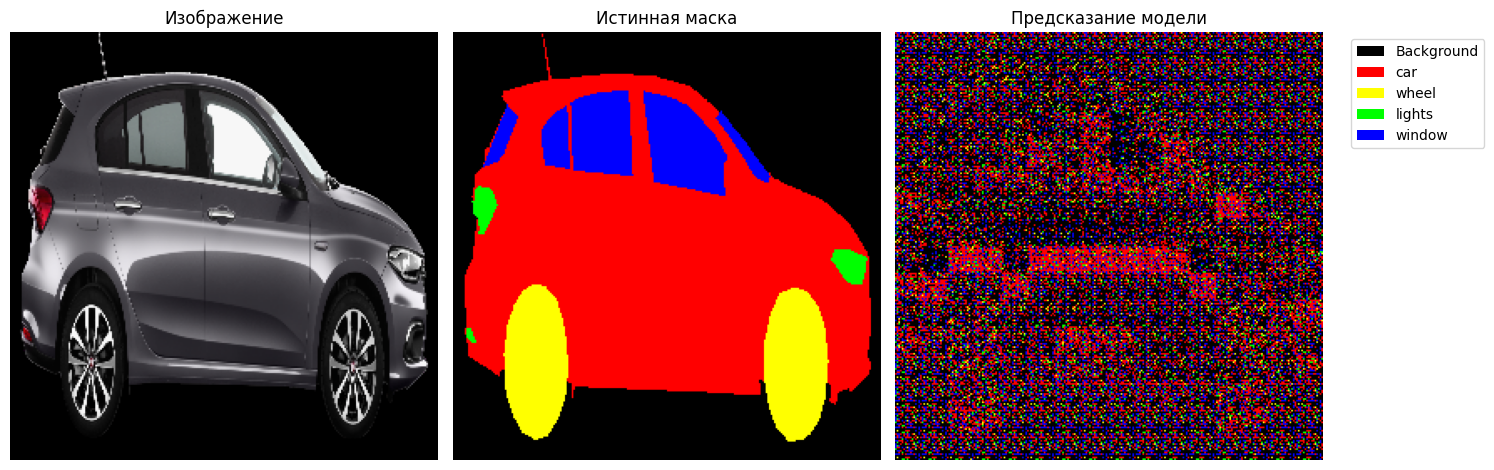

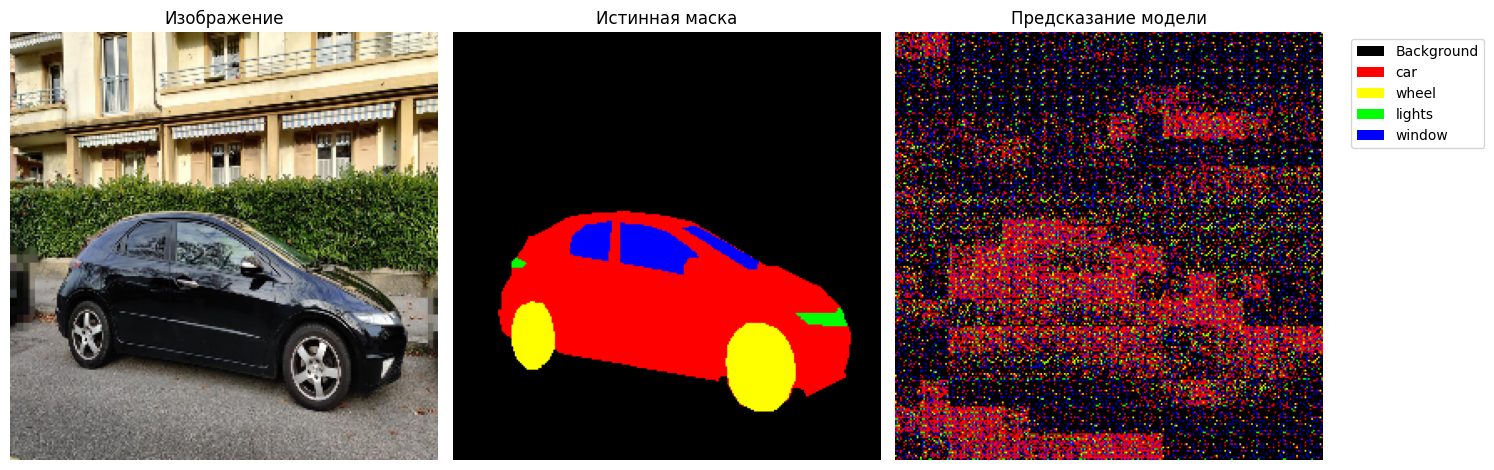

In [76]:
trained_custom_segformer, history = train_model(
    model=custom_segformer,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    epochs=3,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)
visualize_predictions(trained_custom_segformer, train_dataset, DEVICE, num_samples=2)

Результат не впечетляющий, явно модель не успевает обощить, слишком сложная страктуру для такого набора данных. Можно попробовать улучшить, но скорее всего дело сильно лучше не пойдёт

### Улучшенный бейзлайн собственного трансформера

Epoch 1/5


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 00029: reducing learning rate of group 0 to 6.2500e-06.
Train Loss: 1.3294
Val Loss: 1.2540
Train Metrics: 0.1690
Val Metrics: 0.1830
------------------------------
Epoch 2/5


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.2888
Val Loss: 1.2113
Train Metrics: 0.1863
Val Metrics: 0.2003
------------------------------
Epoch 3/5


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.2609
Val Loss: 1.1237
Train Metrics: 0.1958
Val Metrics: 0.2157
------------------------------
Epoch 4/5


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Train Loss: 1.2268
Val Loss: 1.1079
Train Metrics: 0.2071
Val Metrics: 0.2295
------------------------------
Epoch 5/5


Training:   0%|          | 0/19 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Validation:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 00033: reducing learning rate of group 0 to 3.1250e-06.
Train Loss: 1.1943
Val Loss: 1.1075
Train Metrics: 0.2192
Val Metrics: 0.2313
------------------------------


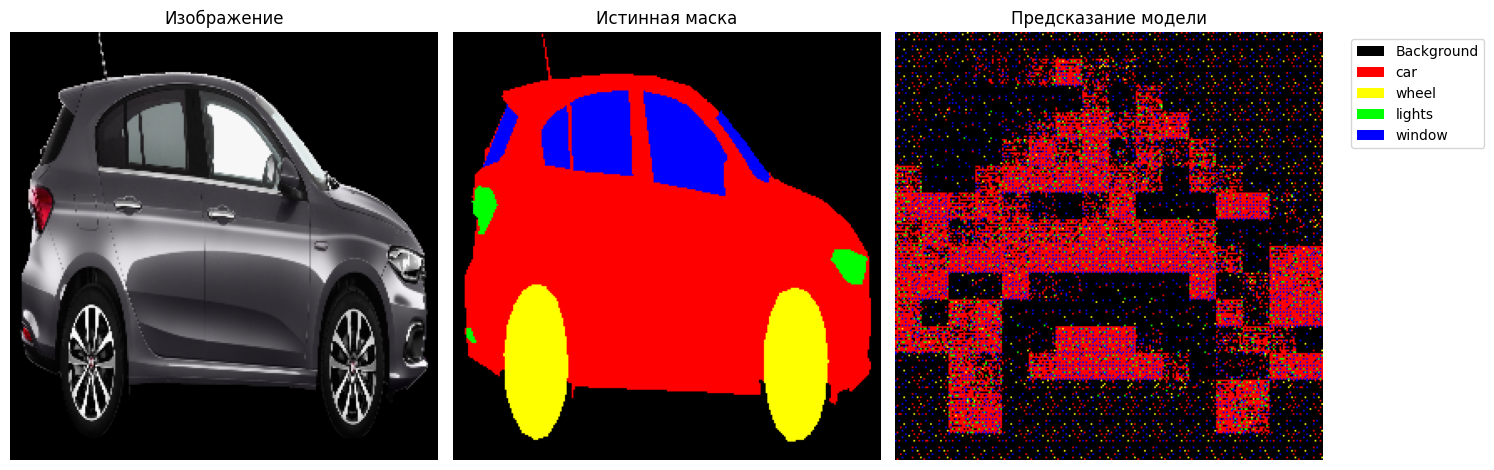

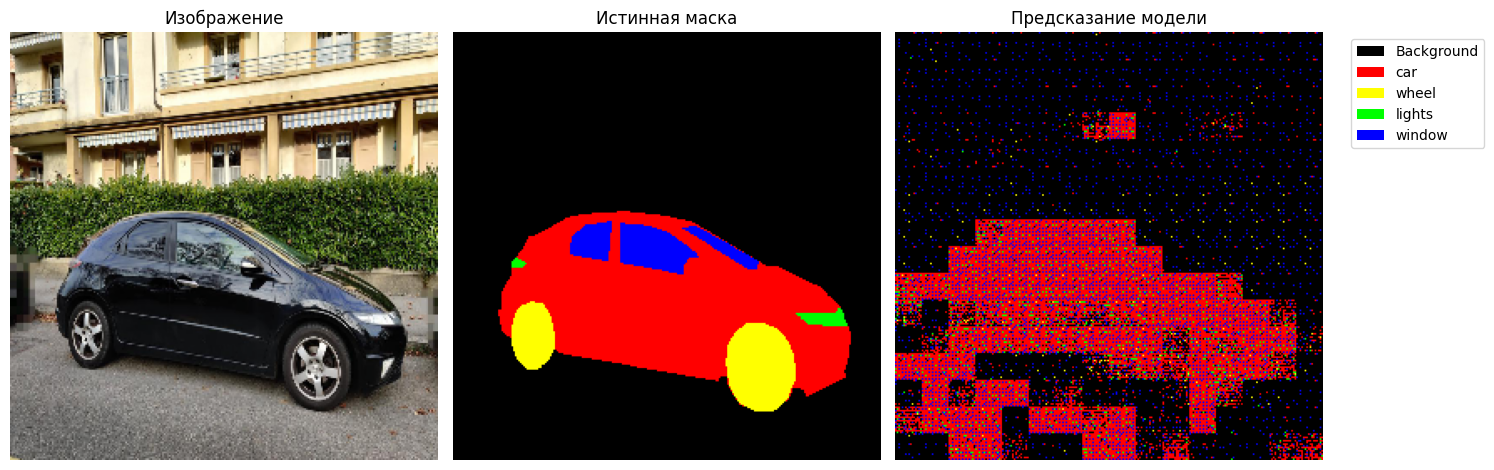

In [77]:
trained_improved_custom_segformer, history = train_model(
    model=custom_segformer,
    train_loader=improved_train_loader,
    val_loader=improved_val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    epochs=5,
    scheduler=scheduler,
    metrics_fn=mean_iou,
)
visualize_predictions(trained_improved_custom_segformer, train_dataset, DEVICE, num_samples=2)

Таким образом улучшить собственную имплементацию не получилась, она проигрывает всем реализациям, в том числе самописной UNet. Хотя видно, что точность продолжает увеличиваться и количество шума на картинке уменьшается. Гипотеза, что необходимо увеличить время обучения

## Сводная таблица результатов

<table>
  <thead>
    <tr>
      <th>Архитектура</th>
      <th>Модификация</th>
      <th>Улучшенная</th>
      <th>IoU</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Unet</td>
      <td>Стандартная</td>
      <td>Нет</td>
      <td>0.6160</td>
    </tr>
    <tr>
      <td>Unet</td>
      <td>Стандартная</td>
      <td>Да</td>
      <td>0.4307</td>
    </tr>
    <tr>
      <td>Unet</td>
      <td>Кастомная</td>
      <td>Нет</td>
      <td>0.2573</td>
    </tr>
    <tr>
      <td>Unet</td>
      <td>Кастомная</td>
      <td>Да</td>
      <td>0.2621</td>
    </tr>
    <tr>
      <td>Segformer</td>
      <td>Стандартная</td>
      <td>Нет</td>
      <td>0.5917</td>
    </tr>
    <tr>
      <td>Segformer</td>
      <td>Стандартная</td>
      <td>Да</td>
      <td>0.6343</td>
    </tr>
    <tr>
      <td>Segformer</td>
      <td>Кастомная</td>
      <td>Нет</td>
      <td>0.1679</td>
    </tr>
    <tr>
      <td>Segformer</td>
      <td>Кастомная</td>
      <td>Да</td>
      <td>0.2342</td>
    </tr>
  </tbody>
</table>


# Заключение

В рамках данной работы были протестированы модели для сегментации частей автомобиля: колесо, корпус, окно, фары. Анализируя метрики IoU, можно сделать следующие выводы:

Стандартная архитектура UNet без улучшений показала наилучший результат с IoU 0.616. Это подтверждает её способность эффективно сегментировать на данном наборе данных в стандартной конфигурации. Кастомные модификации UNet продемонстрировали более низкие IoU (максимум 0.2621), что может говорить о неподходящих кастомных настройках для данной задачи.


Segformer, особенно в стандартной конфигурации с улучшениями, показал лучшую производительность среди всех моделей с наибольшим IoU 0.6343. Это свидетельствует о его потенциале в задаче сегментации на изображениях с автомобилями. Однако кастомные версии Segformer имели значительно более низкий IoU, что указывает на необходимость тонкой настройки кастомных параметров.

Таким образом, в данной работе были протестированы и сравнивались различные модели для сегментации частей автомобиля. Результаты показали, что стандартная архитектура UNet без улучшений показала наилучший результат, а Segformer с улучшениями показал лучшую производительность.